In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<h1>Load and Clean Dataset<h1>

In [2]:
mushroom_train = pd.read_csv("hw1_q3_train_data.csv")

In [3]:
sta = mushroom_train.describe()
sta

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class
count,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000
mean,591.319444,3.937500,2.118056,7.141204,0.785819,1077.006944,8.488426,0.946550,0.548611
std,375.282674,2.209089,2.192044,3.169016,0.700045,799.469663,3.130548,0.292916,0.498208
min,27.000000,0.000000,0.000000,0.000000,0.007532,0.000000,1.000000,0.027372,0.000000
25%,312.750000,2.000000,0.000000,5.000000,0.253448,465.500000,6.000000,0.888450,0.000000
50%,546.000000,5.000000,1.000000,7.000000,0.616743,951.500000,11.000000,0.943195,1.000000
75%,795.500000,6.000000,4.000000,10.000000,1.110564,1525.000000,11.000000,0.943195,1.000000
max,1866.000000,6.000000,6.000000,11.000000,3.747782,3444.000000,12.000000,1.804273,1.000000


In [4]:
mushroom_train.isna().sum()

cap-diameter       0
cap-shape          0
gill-attachment    0
gill-color         0
stem-height        0
stem-width         0
stem-color         0
season             0
class              0
dtype: int64

In [5]:
for col in mushroom_train.columns.drop('class'):
    mean = sta[col].loc['mean']
    std = sta[col].loc['std']
    mushroom_train[col] = (mushroom_train[col] - mean) / std

In [6]:
mushroom_test = pd.read_csv("hw1_q3_test_data.csv")

In [7]:
for col in mushroom_test.columns.drop('class'):
    mean = sta[col].loc['mean']
    std = sta[col].loc['std']
    mushroom_test[col] = (mushroom_test[col] - mean) / std 

<h3>Problem (a) (i)<h3>

We first derive mean and standard deviation for each variable in train set and use z-score to normalize them. Then we apply these means and stds to corresponding variables in test set and use z-score again to normalize.

<h3>Problem (a) (ii)<h3>

I think F1 scores are better because the training set is a little bit imbalanced. And since we care much more about false positive (because classifying a poisonous mushroom into edible!), F1 scores can provide us with some information about fp.

<h1>Build KNN<h1>

In [8]:
# Euclidean Distance
def ed(x1,x2):
    return np.linalg.norm(x1 - x2)

# Manhattan Distance
def md(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return np.sum(np.abs(x1 - x2))

# Chebyshev Distance
def cd(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return np.max(np.abs(x1 - x2))

dis = {
    "ed": ed,
    "md": md,
    "cd": cd
}

In [9]:
class KNN:
    def __init__(self, k, t, m):
        self.k = k
        self.threshold = t
        self.method = m
        
    def fit(self, X_train , y_train):
        self.X_train = X_train
        self.y_train = y_train
    
    def predict(self, X_test):
        results = []
        results = [self._predict(x) for x in X_test.values]
        return np.array(results)
    
    def _predict(self, x):
        n1 = 0
        distances = []
        k_indices = []
        k_nearest_labels = []
        
        # calculate the distance between all samples in training set and this sample x. 
        d = dis[self.method]
        distance = [d(x, x_train) for x_train in self.X_train.values]
        # print(distance)
        
        # fetch indices of k nearest samples
        k_indices = np.argsort(distance)[:int(self.k)]

        # get labels
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        
        # vote for the most frequent label and then return. since it is a binary classification, we can transfer this problem to see which label occupies more than 50% of the label set.
        for i in k_nearest_labels:
            if i == 1:
                n1 = n1 + 1
        if n1/len(k_nearest_labels) > self.threshold:
            label = 1
        else:
            label = 0
        return  label
    
    def accuracy(self, y_true, y_pred):
        return np.sum(y_true == y_pred) / len(y_true)

    def precision(self, y_true, y_pred):
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        return tp / (tp + fp) if (tp + fp) > 0 else 0
    
    def recall(self, y_true, y_pred):
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fn = np.sum((y_pred == 0) & (y_true == 1))
        return tp / (tp + fn) if (tp + fn) > 0 else 0
    
    def f1_score(self, y_true, y_pred):
        p = self.precision(y_true, y_pred)
        r = self.recall(y_true, y_pred)
        return 2 * (p * r) / (p + r) if (p + r) > 0 else 0
    
    def tpr_fpr(self, y_true, y_pred):
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fn = np.sum((y_pred == 0) & (y_true == 1))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        tn = np.sum((y_pred == 0) & (y_true == 0))
        
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        return tpr, fpr

<h3>Problem (b) (i)<h3>

In [10]:
knn = KNN(k=round(np.sqrt(len(mushroom_train)),0),t=0.5,m="ed")

#get training set and test set
X_train = mushroom_train.drop(columns = ['class'])
y_train = mushroom_train['class']
X_test = mushroom_test.drop(columns = ['class'])
y_test = mushroom_test['class']

X_train.columns = range(X_train.shape[1])
X_test.columns = range(X_test.shape[1])

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

accuracy = knn.accuracy(y_test,y_pred)
f1_scores = knn.f1_score(y_test, y_pred)
precisions = knn.precision(y_test, y_pred)
recalls = knn.recall(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precisions}")
print(f"Recall: {recalls}")
print(f"F1 Score: {f1_scores}")

Accuracy: 0.6265432098765432
Precision: 0.689873417721519
Recall: 0.6022099447513812
F1 Score: 0.6430678466076696


<h1>Change Threshold<h1>

<h3>Problem (b) (ii)<h3>

In [11]:
_knn = KNN(k=round(np.sqrt(len(mushroom_train)),0),t=0.5,m="ed")

# get training set and test set
X_train = mushroom_train.drop(columns = ['class'])
y_train = mushroom_train['class']
X_test = mushroom_test.drop(columns = ['class'])
y_test = mushroom_test['class']

X_train.columns = range(X_train.shape[1])
X_test.columns = range(X_test.shape[1])

_knn.fit(X_train, y_train)
y_pred = _knn.predict(X_test)

accuracy = _knn.accuracy(y_test,y_pred)
f1_scores = _knn.f1_score(y_test, y_pred)
precisions = _knn.precision(y_test, y_pred)
recalls = _knn.recall(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precisions}")
print(f"Recall: {recalls}")
print(f"F1 Score: {f1_scores}")

Accuracy: 0.6265432098765432
Precision: 0.689873417721519
Recall: 0.6022099447513812
F1 Score: 0.6430678466076696


<h1>Hyperparameter tuning with cross validation<h1>

<h3>Problem (c) (i)<h3>

In [12]:
# Euclidean Distance
def ed(x1,x2):
    return np.linalg.norm(x1 - x2)

# Manhattan Distance
def md(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return np.sum(np.abs(x1 - x2))

# Chebyshev Distance
def cd(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return np.max(np.abs(x1 - x2))

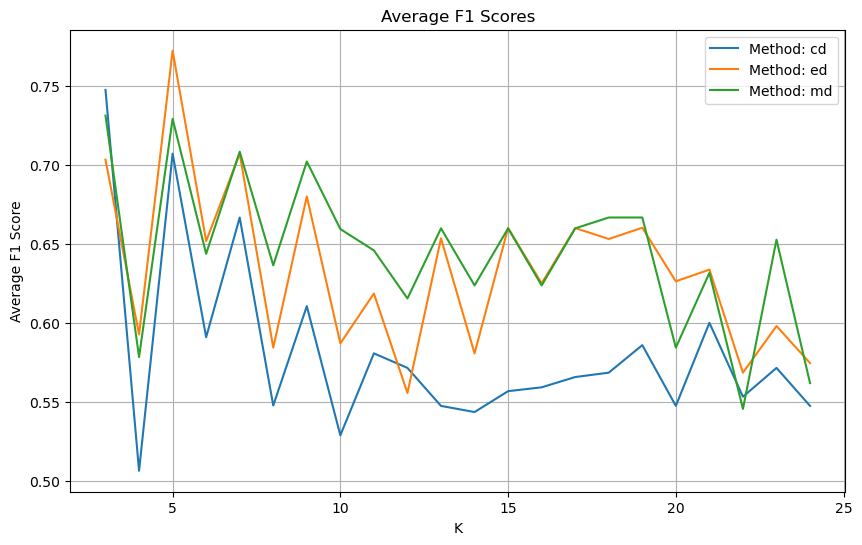

Best average F1 score on validation set: 0.7722772277227722
Best k: 5, best method: ed


In [13]:
X_t = pd.read_csv("hw1_q3_train_data.csv").drop(columns=['class'])
y_t = pd.read_csv("hw1_q3_train_data.csv")['class']

X_t.columns = range(X_train.shape[1])

# 5-fold CV
k_folds = 5
n = X_t.shape[0]
fold_size = n // k_folds

indices = np.random.permutation(n)

for fold in range(k_folds):
    # Split training set and validation set
    val_indices = indices[fold * fold_size: (fold + 1) * fold_size]
    train_indices = np.concatenate([indices[:fold * fold_size], indices[(fold + 1) * fold_size:]])

    X_train = X_t.iloc[train_indices]
    y_train = y_t.iloc[train_indices]
    
    X_val = X_t.iloc[val_indices]
    y_val = y_t.iloc[val_indices]
    
    # Noramlization
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)

    X_train = (X_train - mean) / std
    X_val = (X_val - mean) / std
    
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    
    # Tuning
    knn_model_list = {}
    f1_scores_drawing = []
    
    for k in range(3,25,1):
        for method in ["ed","md","cd"]:
            y_val_pred = []
            f1_scores = 0
            
            knn_model_list[(k, method)] = KNN(k=k,t=0.5,m=method)
            knn_model_list[(k, method)].fit(X_train, y_train)
        
            y_val_pred = knn_model_list[(k, method)].predict(X_val)
            f1_scores = knn_model_list[(k, method)].f1_score(y_val,y_val_pred)
            f1_scores_drawing.append({"k": k, "method": method, "f1_score": f1_scores, "fold": fold})
            
f1_scores_drawing = pd.DataFrame(f1_scores_drawing)

# Calculate average F1 scores
f1_scores_drawing = f1_scores_drawing.groupby(['k', 'method'], as_index=False).mean()

# Plot the results
plt.figure(figsize=(10, 6))

for method in f1_scores_drawing['method'].unique():
    data_by_method = f1_scores_drawing[f1_scores_drawing['method'] == method]
    plt.plot(data_by_method['k'], data_by_method['f1_score'], label=f"Method: {method}")

plt.title("Average F1 Scores")
plt.xlabel("K")
plt.ylabel("Average F1 Score")
plt.legend()
plt.grid(True)

plt.show()

# Find the best parameter
best_parameter_index = f1_scores_drawing['f1_score'].idxmax()

best_k = f1_scores_drawing.loc[best_parameter_index, 'k']
best_method = f1_scores_drawing.loc[best_parameter_index, 'method']
best_f1_score = f1_scores_drawing.loc[best_parameter_index, 'f1_score']

print(f"Best average F1 score on validation set: {best_f1_score}")
print(f"Best k: {best_k}, best method: {best_method}")

<h1> Applying Best Parameter to Test Set<h1>

<h3> Problem (c) (ii)<h3>

In [14]:
knn_best = KNN(k=best_k,t=0.5,m=best_method)

X_train = mushroom_train.drop(columns = ['class'])
y_train = mushroom_train['class']
X_test = mushroom_test.drop(columns = ['class'])
y_test = mushroom_test['class']

X_train.columns = range(X_train.shape[1])
X_test.columns = range(X_test.shape[1])

knn_best.fit(X_train, y_train)
y_pred = knn_best.predict(X_test)

f1_scores = knn_best.f1_score(y_test, y_pred)

print(f"F1 Score: {f1_scores}")

F1 Score: 0.7787114845938375


<h1>ROC Curve and AUC<h1>

<h3> Problem (d) (i)<h3>

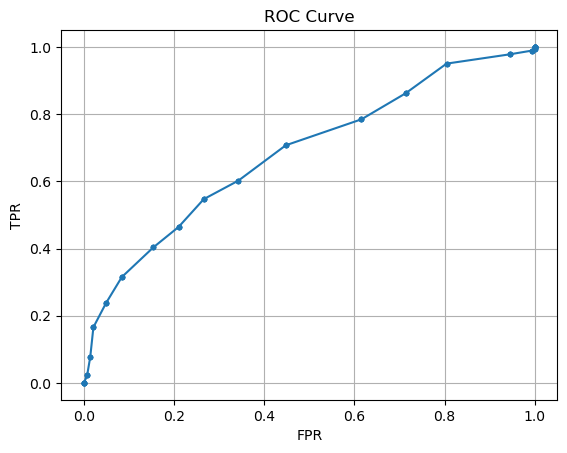

In [15]:
X_train = mushroom_train.drop(columns = ['class'])
y_train = mushroom_train['class']
X_test = mushroom_test.drop(columns = ['class'])
y_test = mushroom_test['class']

X_train.columns = range(X_train.shape[1])
X_test.columns = range(X_test.shape[1])

knn = KNN(k=round(np.sqrt(len(mushroom_train)),0),t=0.5,m="ed")
knn.fit(X_train, y_train)

thresholds = np.linspace(0, 1, 100)
tpr_list = []
fpr_list = []

# Get tpr and fpr
for t in thresholds:
    knn.threshold = t
    y_pred = knn.predict(X_test)
    tpr, fpr = knn.tpr_fpr(y_test, y_pred)
    tpr_list.append(tpr)
    fpr_list.append(fpr)

# Draw ROC Curve
plt.figure()
plt.plot(fpr_list, tpr_list, marker='.')
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid(True)
plt.show()

<h3> Problem (d) (ii)<h3>

In [16]:
def auc(fpr_list, tpr_list):
    auc = 0
    for i in range(1, len(fpr_list)):
        auc = auc + (fpr_list[i - 1] - fpr_list[i]) * (tpr_list[i] + tpr_list[i - 1]) / 2
    return auc

auc = auc(fpr_list, tpr_list)
print(f"AUC:{auc}")

AUC:0.6851601437236796
